In this analysis, it was used the data made available by the **Infodengue** (https://info.dengue.mat.br/) . It was used the data until the end of the 2021 year for João Pessoa city. 

The data is saved in the data folder. It was named as: `{disease}_{ibge_code}.csv` and assigned with `cluster` in the end when it refers to the clustered data. 

Let's look at the dengue and chik data for this case. Note that we have some statistics related to humidity, temperature, and the number of cases. These features will be used to forecast the number of dengue cases reported. 

In [1]:
import sys
import pickle
sys.path.append('..')
import pandas as pd
from datetime import datetime
from pgbm_model import qf_prediction
import matplotlib.pyplot as plt
from lstm import transf_chik_pred
from lstm import apply_dengue_chik
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from pgbm_model import  cross_dengue_chik_prediction
from sklearn.metrics import mean_squared_error as mse 

In [2]:
CITY = 2507507
CITY_NAME = 'João Pessoa'
STATE = 'PB'
END_DATE = '2021-01-01' # assign the last day used to train the dengue model
INI_DATE_CHIK = '2021-01-01'  # assign the first day used to retrain the model with chik data 
END_TRAIN_CHIK = '2021-05-01' # assign the last day used to retrain the model with chik data
END_DATE_CHIK = '2022-01-01'  # assign the last day of chik data used to apply the trained model 
INI_EVALUATE = '2021-05-02' # assign the first day used to evaluate the trained model (transfer learning)
END_EVALUATE = '2021-06-06' # assign the last day used to evaluate the trained model (transfer learning)
PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 

In [3]:
df_dengue = pd.read_csv(f'../data/dengue_{CITY}.csv', index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_2507507,casos_est_2507507,casos_est_min_2507507,casos_est_max_2507507,p_rt1_2507507,p_inc100k_2507507,temp_min_2507507,temp_max_2507507,umid_min_2507507,pressao_min_2507507
2010-01-03,0,0.0,0,0,0.000000e+00,0.000000,25.000000,29.666667,56.666667,1009.666667
2010-01-10,0,0.0,0,0,0.000000e+00,0.000000,25.000000,29.428571,59.142857,1010.142857
2010-01-17,0,0.0,0,0,0.000000e+00,0.000000,25.000000,29.142857,63.000000,1011.571429
2010-01-24,0,0.0,0,0,0.000000e+00,0.000000,24.142857,29.000000,67.000000,1010.714286
2010-01-31,0,0.0,0,0,0.000000e+00,0.000000,24.857143,30.000000,56.714286,1009.142857
...,...,...,...,...,...,...,...,...,...,...
2022-05-29,408,500.0,432,701,5.104868e-01,61.161255,23.000000,27.428571,77.831345,1012.571429
2022-06-05,376,498.5,405,778,5.771039e-01,60.977770,23.571429,28.000000,77.063711,1010.714286
2022-06-12,162,310.0,200,804,7.250031e-10,37.919980,23.000000,26.857143,77.824348,1012.000000
2022-06-19,44,230.0,81,912,6.661338e-16,28.134178,23.285714,28.428571,66.299810,1013.142857


Note that the chik dataset has the same columns

In [4]:
df_chik = pd.read_csv(f'../data/chik_{CITY}.csv', index_col = 'Unnamed: 0' )
df_chik.index = pd.to_datetime(df_chik.index)
df_chik

,casos_2507507,casos_est_2507507,casos_est_min_2507507,casos_est_max_2507507,p_rt1_2507507,p_inc100k_2507507,temp_min_2507507,temp_max_2507507,umid_min_2507507,pressao_min_2507507
2010-01-03,0,0.0,0,0,0.000000,0.000000,25.000000,29.666667,56.666667,1009.666667
2010-01-10,0,0.0,0,0,0.000000,0.000000,25.000000,29.428571,59.142857,1010.142857
2010-01-17,0,0.0,0,0,0.000000,0.000000,25.000000,29.142857,63.000000,1011.571429
2010-01-24,0,0.0,0,0,0.000000,0.000000,24.142857,29.000000,67.000000,1010.714286
2010-01-31,0,0.0,0,0,0.000000,0.000000,24.857143,30.000000,56.714286,1009.142857
...,...,...,...,...,...,...,...,...,...,...
2022-05-29,127,200.0,143,414,0.957249,24.464502,23.000000,27.428571,77.831345,1012.571429
2022-06-05,83,192.0,110,510,0.627318,23.485922,23.571429,28.000000,77.063711,1010.714286
2022-06-12,51,210.0,90,631,0.791207,25.687727,23.000000,26.857143,77.824348,1012.000000
2022-06-19,39,247.5,82,1029,0.987449,30.274822,23.285714,28.428571,66.299810,1013.142857


The main difference between the datasets above and the datasets with names ended with `cluster` is the number of columns. This dataset has columns with data from other cities. The city is identified by a 7-number code. These cities was clusterized with João Pessoa (in this case) using a hierarchical clusterization algorithm. 

In [5]:
df_chik_cluster = pd.read_csv(f'../data/chik_{CITY}_cluster.csv', index_col = 'Unnamed: 0' )
df_chik_cluster.index = pd.to_datetime(df_chik_cluster.index)
df_chik_cluster

,casos_2503001,casos_est_2503001,casos_est_min_2503001,casos_est_max_2503001,p_rt1_2503001,p_inc100k_2503001,temp_min_2503001,temp_max_2503001,umid_min_2503001,pressao_min_2503001,...,casos_2504306,casos_est_2504306,casos_est_min_2504306,casos_est_max_2504306,p_rt1_2504306,p_inc100k_2504306,temp_min_2504306,temp_max_2504306,umid_min_2504306,pressao_min_2504306
2010-01-03,0,0.0,0,0,0.0,0.0,25.000000,29.666667,56.666667,1009.666667,...,0,0.0,0,0,0.000000,0.000000,22.666667,31.333333,48.000000,1010.666667
2010-01-10,0,0.0,0,0,0.0,0.0,25.000000,29.428571,59.142857,1010.142857,...,0,0.0,0,0,0.000000,0.000000,22.000000,30.857143,46.571429,1011.000000
2010-01-17,0,0.0,0,0,0.0,0.0,25.000000,29.142857,63.000000,1011.571429,...,0,0.0,0,0,0.000000,0.000000,22.142857,30.571429,46.857143,1012.714286
2010-01-24,0,0.0,0,0,0.0,0.0,24.142857,29.000000,67.000000,1010.714286,...,0,0.0,0,0,0.000000,0.000000,21.714286,30.285714,48.142857,1011.571429
2010-01-31,0,0.0,0,0,0.0,0.0,24.857143,30.000000,56.714286,1009.142857,...,0,0.0,0,0,0.000000,0.000000,22.428571,31.142857,49.000000,1010.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-29,0,0.0,0,0,0.0,0.0,23.000000,27.428571,77.831345,1012.571429,...,1,1.0,1,1,0.812030,3.259028,20.285714,25.428571,76.269180,1015.000000
2022-06-05,0,0.0,0,0,0.0,0.0,23.571429,28.000000,77.063711,1010.714286,...,0,0.0,0,0,0.000000,0.000000,20.857143,26.142857,74.331669,1013.000000
2022-06-12,0,0.0,0,0,0.0,0.0,23.000000,26.857143,77.824348,1012.000000,...,3,3.0,3,3,0.907023,9.777082,20.000000,24.714286,76.677290,1014.142857
2022-06-19,0,0.0,0,0,0.0,0.0,23.285714,28.428571,66.299810,1013.142857,...,2,2.0,2,2,0.715112,6.518055,20.000000,26.000000,71.428282,1015.428571


We need to have this kind of data because, in our tests, the gradient boosting tree model perform betters when using the cluster data, while the neural network model performed better using only the city's data. 

Let's plot this two incidence curver (dengue and chik):

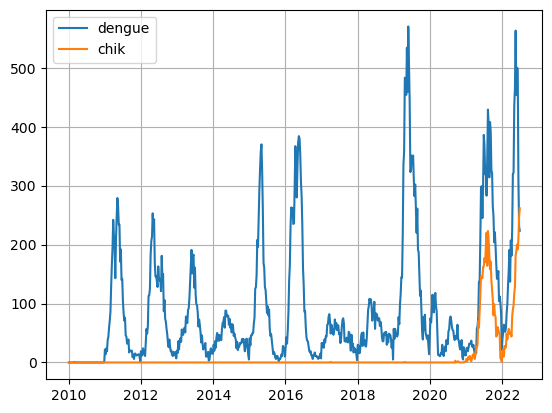

In [6]:
fig, ax = plt.subplots()

ax.plot(df_dengue[f'casos_est_{CITY}'], label = 'dengue')

ax.plot(df_chik[f'casos_est_{CITY}'], label = 'chik')

plt.legend()
plt.grid()
plt.show()

### Neural network model (NN)

First, we make the prediction using the data up to 2021-01-01 and use 25% data to test the model. It used 25% of the training data as validation data. It used the early stop config to train the model faster to monitor the loss function. 

Before applying the nn model we compute the first derivative of our target (the incidence curve) and added it as a feature. 

The neural newtork model is constructed using the `build_model` function. This function create a model with a bidirectional LSTM layer and a simple LSTM layer. We use the last 4 (look_back parameter) observations to predict the next 4 (predict_n parameter). 

The predictions of this models are saved in the path:
'./predictions/lstm/lstm_{city}_dengue_{label}.pkl'

The model is saved in the path: 
'./saved_models/lstm/trained_{geocode}_model_{label}.h5'

2022-09-02 18:27:22.427318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compilation Time :  0.0030798912048339844
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 11)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             1280      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 

Epoch 32/100
318/318 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.4654 - mape: 1001316.0000 - mse: 0.0033 - val_loss: 0.0037 - val_accuracy: 0.3458 - val_mape: 59.0573 - val_mse: 0.0068
Epoch 33/100
318/318 [==============================] - 1s 4ms/step - loss: 0.0020 - accuracy: 0.4591 - mape: 1044095.8125 - mse: 0.0032 - val_loss: 0.0042 - val_accuracy: 0.3551 - val_mape: 56.9744 - val_mse: 0.0079
Epoch 34/100
318/318 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 0.4560 - mape: 852397.5625 - mse: 0.0035 - val_loss: 0.0041 - val_accuracy: 0.3271 - val_mape: 63.9326 - val_mse: 0.0073
Epoch 35/100
318/318 [==============================] - 1s 5ms/step - loss: 0.0022 - accuracy: 0.4403 - mape: 1193145.8750 - mse: 0.0035 - val_loss: 0.0038 - val_accuracy: 0.2991 - val_mape: 58.4238 - val_mse: 0.0068
Epoch 36/100
318/318 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.4623 - mape: 1216882.5000 - mse: 0.0

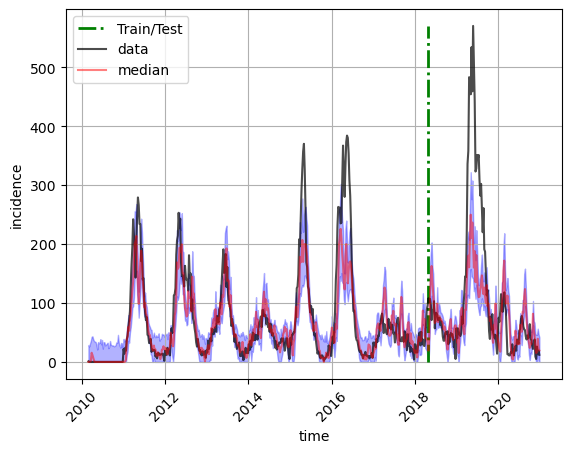

CPU times: user 2min 58s, sys: 9.08 s, total: 3min 7s
Wall time: 2min 37s


,0,1,2,3
mean_absolute_error,20.548961,24.049491,28.602497,32.700891
explained_variance_score,0.816093,0.760239,0.689739,0.612619
mean_squared_error,1851.627685,2328.895875,3000.401787,3731.406895
mean_squared_log_error,0.191630,0.256209,0.362162,0.398820
median_absolute_error,8.935358,11.062829,12.341154,15.811620
r2_score,0.797813,0.745605,0.672087,0.592057


In [7]:
%%time

model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 0.75, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle')

### PGBM model (ml) 

In this case, we use the last 4 observations to predict the next 4. Since a GBT (gradient boosting tree) model has a 1D target, we trained four different models each one specialized in predicting one of the next four observations.

The predictions are saved in the path: './predictions/pgbm/pgbm_{city}_{doenca}_predictions.pkl'

The models are saved in the path:
'./saved_models/pgbm/{city}_{doenca}_city_model_{d}_pgbm.pt'
where d is in the arange 1 to 4. 


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 74.1425
Estimator 1/100, Train metric: 67.5164
Estimator 2/100, Train metric: 61.4987
Estimator 3/100, Train metric: 56.0270
Estimator 4/100, Train metric: 51.0325
Estimator 5/100, Train metric: 46.5838
Estimator 6/100, Train metric: 42.4992
Estimator 7/100, Train metric: 38.8019
Estimator 8/100, Train metric: 35.4283
Estimator 9/100, Train metric: 32.4235
Estimator 10/100, Train metric: 29.6649
Estimator 11/100, Train metric: 27.1824
Estimator 12/100, Train metric: 24.8810
Estimator 13/100, Train metric: 22.8344
Estimator 14/100, Train metric: 20.9371
Estimator 15/100, Train metric: 19.2274
Estimator 16/100, Train metric: 17.6765
Estimator 17/100, Train metric: 16.2631
Estimator 18/100, Train metric: 14.9858
Estimator 19/100, Train metric: 13.8020
Estimator 20/100, Train metric: 12.7408
Estimator 21/100, Train metric: 11.7737
Estimator 22/100, Train metric: 10.9045
Estimator 23/100, Train metric: 10.0984
Estimator 24/100, Train metric: 9.3808
Estimator 2

Estimator 10/100, Train metric: 30.7172
Estimator 11/100, Train metric: 28.1851
Estimator 12/100, Train metric: 25.9099
Estimator 13/100, Train metric: 23.8328
Estimator 14/100, Train metric: 21.9691
Estimator 15/100, Train metric: 20.2543
Estimator 16/100, Train metric: 18.6869
Estimator 17/100, Train metric: 17.2861
Estimator 18/100, Train metric: 16.0048
Estimator 19/100, Train metric: 14.8441
Estimator 20/100, Train metric: 13.7945
Estimator 21/100, Train metric: 12.8359
Estimator 22/100, Train metric: 11.9322
Estimator 23/100, Train metric: 11.1457
Estimator 24/100, Train metric: 10.3981
Estimator 25/100, Train metric: 9.7110
Estimator 26/100, Train metric: 9.1281
Estimator 27/100, Train metric: 8.5840
Estimator 28/100, Train metric: 8.1229
Estimator 29/100, Train metric: 7.6760
Estimator 30/100, Train metric: 7.2814
Estimator 31/100, Train metric: 6.9369
Estimator 32/100, Train metric: 6.6083
Estimator 33/100, Train metric: 6.3193
Estimator 34/100, Train metric: 6.0783
Estimator 

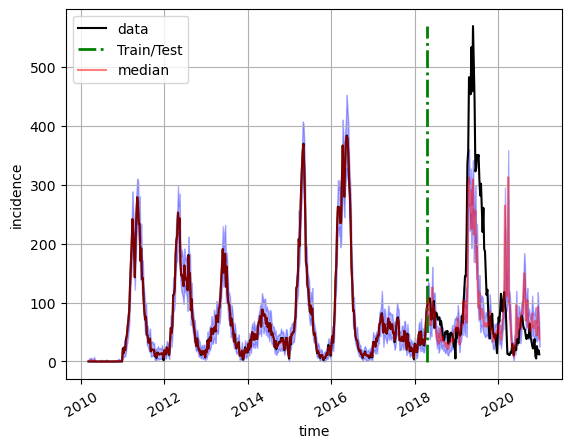

CPU times: user 14min 7s, sys: 44.6 s, total: 14min 52s
Wall time: 5min 20s


In [8]:
%%time

preds, preds25, preds975, X_train, targets = qf_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK,
                                                           doenca = 'dengue', ratio = 0.75, ini_date = None,
                                                           end_date = END_DATE)
   

### Comparing the Neural and ML model 

In this section we compare the performance of the ML and NN model. 

In [9]:
with open(f'../predictions/lstm/lstm_{CITY}_dengue_msle.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'../predictions/pgbm/pgbm_{CITY}_{doenca}_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

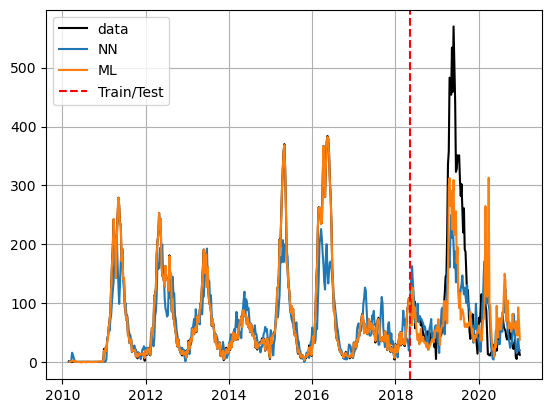

In [10]:
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.axvline(data_ml['dates'][data_ml['train_size']], color = 'red', ls = '--', label = 'Train/Test') # refered to the ML model 

plt.grid()
plt.legend()
plt.show()

Let's compare the error of this models in the test data: 

In [11]:
print('NN error (RMSE):', mse(data_nn['target'][data_nn['xdata'].shape[0]:, -1] * data_nn['factor'], data_nn['pred'].iloc[data_nn['xdata'].shape[0]:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4+ data_ml['train_size']:], data_ml['preds'][data_ml['train_size']:], squared = False))

NN error (RMSE): 94.85129333457574
ML error (RMSE): 92.72874023473527


Looking at the error above we can see that besides comsume more time training, the neural network model (nn) outperform the machine learning model (ml)

We will know use this models to predict the chik outbreak in 2021. In order to do this, we will retrain the nn model and the ml model using the dengue data up to '2021-01-01' and apply the model in the chik data between '2021-01-01' and '2022-01-01'

The label parameter is used as a flag to make difference, if necessary, between the models saved, since this model takes a lot of time to be trained


Compilation Time :  0.005217075347900391
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 11)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             1280      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                

Epoch 32/100
423/423 [==============================] - 2s 5ms/step - loss: 0.0026 - accuracy: 0.4137 - mape: 1547121.7500 - mse: 0.0043 - val_loss: 0.0080 - val_accuracy: 0.2676 - val_mape: 56.5064 - val_mse: 0.0175
Epoch 33/100
423/423 [==============================] - 2s 5ms/step - loss: 0.0023 - accuracy: 0.4113 - mape: 1005869.3750 - mse: 0.0039 - val_loss: 0.0055 - val_accuracy: 0.3099 - val_mape: 61.0365 - val_mse: 0.0116


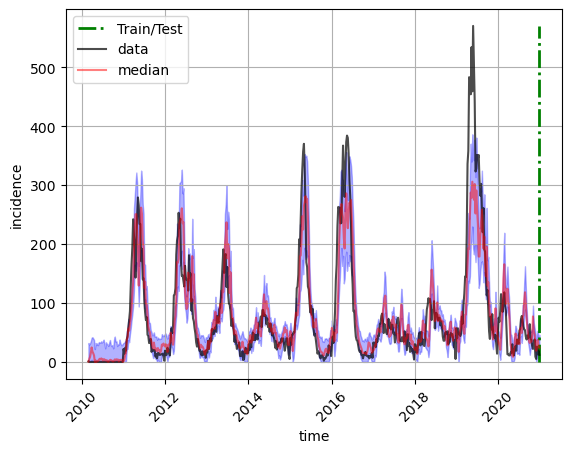

CPU times: user 3min 4s, sys: 9.25 s, total: 3min 13s
Wall time: 2min 41s


,0,1,2,3
mean_absolute_error,17.079933,21.158859,25.062046,29.741666
explained_variance_score,0.905457,0.866571,0.806507,0.740675
mean_squared_error,874.603111,1231.344406,1770.535648,2374.668989
mean_squared_log_error,0.199076,0.285363,0.349248,0.498831
median_absolute_error,10.447082,12.337232,13.375499,15.438700
r2_score,0.904498,0.865495,0.806498,0.740385


In [12]:
%%time

model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back= LOOK_BACK, batch_size=1, loss = 'msle')

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 1, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK,
                  label = 'msle_all')

Estimator 0/100, Train metric: 87.0797
Estimator 1/100, Train metric: 79.3945
Estimator 2/100, Train metric: 72.4465
Estimator 3/100, Train metric: 66.1343
Estimator 4/100, Train metric: 60.4241
Estimator 5/100, Train metric: 55.2327
Estimator 6/100, Train metric: 50.5173
Estimator 7/100, Train metric: 46.2463
Estimator 8/100, Train metric: 42.3538
Estimator 9/100, Train metric: 38.8660
Estimator 10/100, Train metric: 35.6630
Estimator 11/100, Train metric: 32.8057
Estimator 12/100, Train metric: 30.2118
Estimator 13/100, Train metric: 27.8636
Estimator 14/100, Train metric: 25.7206
Estimator 15/100, Train metric: 23.7889
Estimator 16/100, Train metric: 22.0385
Estimator 17/100, Train metric: 20.4614
Estimator 18/100, Train metric: 18.9923
Estimator 19/100, Train metric: 17.6758
Estimator 20/100, Train metric: 16.4720
Estimator 21/100, Train metric: 15.3269
Estimator 22/100, Train metric: 14.3268
Estimator 23/100, Train metric: 13.4162
Estimator 24/100, Train metric: 12.6177
Estimator 

Estimator 10/100, Train metric: 37.1320
Estimator 11/100, Train metric: 34.3160
Estimator 12/100, Train metric: 31.7401
Estimator 13/100, Train metric: 29.3995
Estimator 14/100, Train metric: 27.3063
Estimator 15/100, Train metric: 25.3622
Estimator 16/100, Train metric: 23.6097
Estimator 17/100, Train metric: 22.0097
Estimator 18/100, Train metric: 20.5784
Estimator 19/100, Train metric: 19.2361
Estimator 20/100, Train metric: 18.0640
Estimator 21/100, Train metric: 16.9736
Estimator 22/100, Train metric: 16.0355
Estimator 23/100, Train metric: 15.2147
Estimator 24/100, Train metric: 14.3798
Estimator 25/100, Train metric: 13.7082
Estimator 26/100, Train metric: 13.0157
Estimator 27/100, Train metric: 12.4589
Estimator 28/100, Train metric: 11.9247
Estimator 29/100, Train metric: 11.4279
Estimator 30/100, Train metric: 11.0087
Estimator 31/100, Train metric: 10.5829
Estimator 32/100, Train metric: 10.1189
Estimator 33/100, Train metric: 9.7545
Estimator 34/100, Train metric: 9.4361
Es

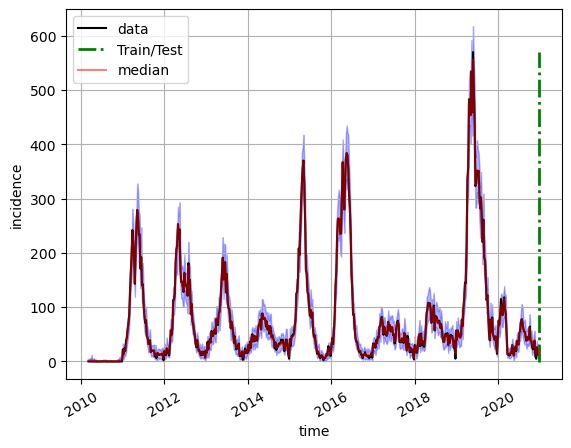

In [13]:

preds, preds25, preds975, X_train, targets = qf_prediction(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_DATE, end_date = END_DATE)
   

Apply the ml model in chik:

The predictions are saved in the path: './predictions/pgbm/pgbm_{city}_chik_cross_predictions.pkl'

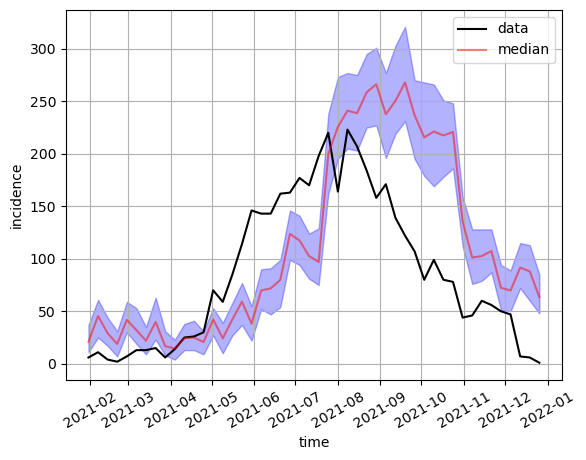

In [14]:

preds, preds25, preds975, X_data, targets = cross_dengue_chik_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK, ini_date = INI_DATE_CHIK, end_date = END_DATE_CHIK)
    

Apply the NN model into the chik data:

The predictions is saved in the path: './predictions/lstm/lstm_{city}_dengue_model_chik_predictions.pkl'

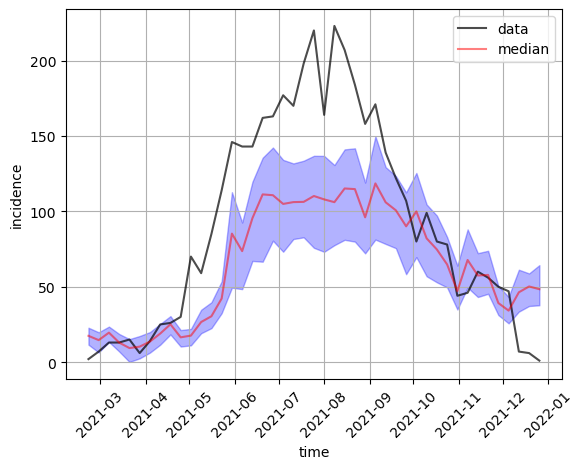

In [15]:

metrics = apply_dengue_chik(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, 
                     end_date = END_DATE_CHIK, look_back = LOOK_BACK,
                     predict_n = PREDICT_N,  label_m = f'msle_all' )

Compare the predictions:

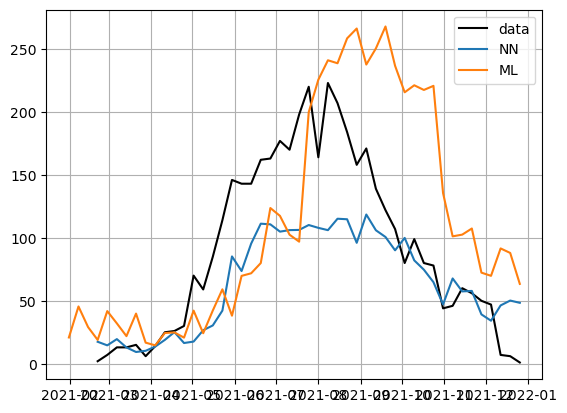

In [16]:
with open(f'../predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'../predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)
        
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.show()

Compute the RMSE error: 

In [17]:

print('NN error (RMSE):', mse(data_nn['target'][:, -1] * data_nn['factor'], data_nn['pred'].iloc[:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4:], data_ml['preds'], squared = False))

NN error (RMSE): 48.12078383177996
ML error (RMSE): 71.48593479542518


### Transfer learning 

Here we use the transfer learning technique to improve the performance of the predictions of the dengue model in the chik data. To do this, we retrain the output layer of the dengue model, and after it, retrain the model (all the layers, that's the fine tunning step). In this step, we need to pay attention to overfitting. It can be necessary to decrease the learning rate. 

We use the transfer learning technique since it is not possible to train a good ml or nn model with few observations, as in the case of the  chik outbreak in João Pessoa in 2021. 

Compilation Time :  0.005036115646362305
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 11)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             1280      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 4)                 36        
                  

10/10 [==============================] - 0s 4ms/step - loss: 8.3186e-04 - accuracy: 0.5000 - mape: 89.3990 - mse: 9.4265e-04 
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 8.8860e-04 - accuracy: 0.5000 - mape: 92.6778 - mse: 0.0010 
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 8.2135e-04 - accuracy: 0.4000 - mape: 90.1312 - mse: 9.2955e-04
Epoch 54/100
10/10 [==============================] - 0s 4ms/step - loss: 8.3536e-04 - accuracy: 0.5000 - mape: 93.6694 - mse: 9.4436e-04
Epoch 55/100
10/10 [==============================] - 0s 8ms/step - loss: 8.4893e-04 - accuracy: 0.4000 - mape: 94.1785 - mse: 9.5980e-04
Epoch 56/100
10/10 [==============================] - 0s 5ms/step - loss: 8.2084e-04 - accuracy: 0.5000 - mape: 94.9546 - mse: 9.2713e-04
Epoch 57/100
10/10 [==============================] - 0s 4ms/step - loss: 9.2476e-04 - accuracy: 0.4000 - mape: 99.4887 - mse: 0.0010    
Epoch 58/100
10/10 [=============================

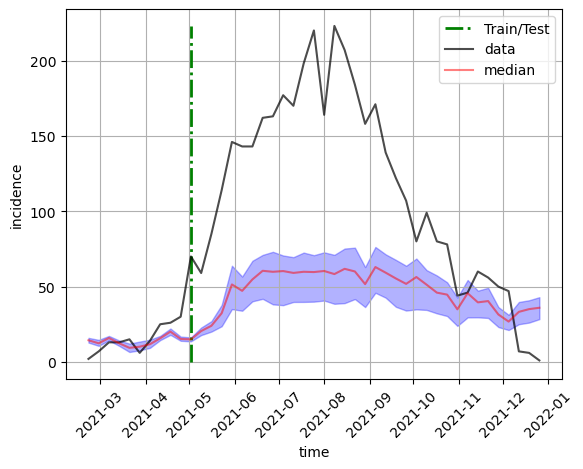

In [18]:
transf_chik_pred(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, end_train_date = END_TRAIN_CHIK,  
                            end_date = END_DATE_CHIK, filename = f'../saved_models/lstm/trained_{CITY}_model_msle_all.h5',  epochs =100, features = 11,  
                            predict_n = 4, look_back = 4, loss = 'msle', validation_split = 0.0,
                            label = f'transf_chik')

To apply the transfer learning technique we use as train data the chik data up to '2021-05-01'. We can see that after this day the model has good performance considering the next month (data between '2021-05-01' and '2021-06-01'). 

To evaluate the improvement in the performance of the model we compute the following skill score: 

$$ SS = 1 - \cfrac{RMSE_{forecast}}{RMSE_{reference}}$$ 

In the formula, the reference represent the error of the model used as reference and the forecast represent the new model that we want to compare the performance. If the SS value is above 0 or new model is better than the reference model, otherwise it's worst. 

In [19]:
def ss(forecast, reference, target):
    
    rmse_f = mse(target, forecast, squared = False )
    
    rmse_r = mse(target, reference, squared = False)
    
    return 1 - (rmse_f/rmse_r)

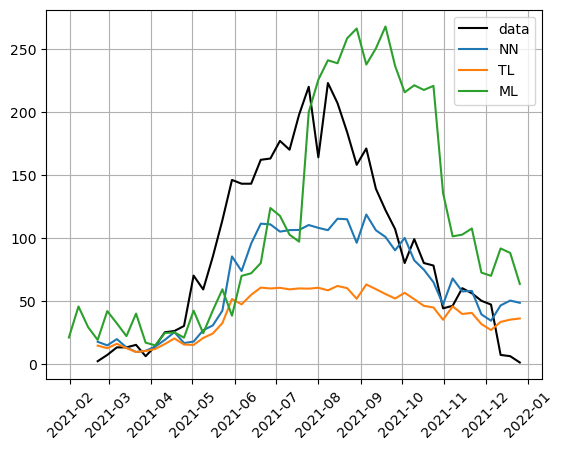

In [20]:
with open(f'../predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'../predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

with open(f'../predictions/lstm/tl_{CITY}_transf_chik.pkl', 'rb') as f:
        data_tl = pickle.load(f) 
        

plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_tl['indice'][7:],data_tl['pred'].iloc[:,-1] * data_tl['factor'], label = 'TL')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [21]:
ini_index = data_nn['indice'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d'))
end_index = data_nn['indice'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))

print('SS compared to NN:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_nn['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_nn['factor']))
print('SS compared to ML:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_ml['preds'][ data_ml['dates'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d')): data_ml['dates'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))] ))


SS compared to NN: -0.23574981273704565
SS compared to ML: -0.13704527890779583


### Retrain the dengue model with a custom loss function 

To specialize our lstm dengue model to predict better the peak of cases we propose a custom loss function. This function gives a weight of 10 to the predictions of ascending cases in the train data. 

This weight is given to the observations in the training data, where the fourth value is bigger than the second value of the target data. (Remember it is an array of length four since we forecast the next 4 observations).  

```
def custom_loss_msle(p = 1):
    """
    :param p: 
    """
    
    def my_loss_msle(y_true, y_pred):
        """
        :param y_true:
        :param y_pred: 
        """

        def f1(): 
            
            loss = tf.math.log(tf.math.add(y_true, 1)/ tf.math.add(y_pred, 1))
    
            loss = tf.square(loss)
        
            return tf.multiply(loss, p) 
        
        def f2(): 
            
            loss = tf.math.log(tf.math.add(y_true, 1)/ tf.math.add(y_pred, 1))
    
            loss = tf.square(loss)
        
            return loss

        msle = tf.cond(tf.less(tf.gather(y_true, 0)[1],tf.gather(y_true, 0)[3]) , 
                                     true_fn = f1,
                                     false_fn = f2 )

        return tf.reduce_mean(msle) 
    
    return my_loss_msle 
```


In [22]:
from lstm import custom_loss_msle

Compilation Time :  0.0026988983154296875
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 11)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             1280      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)               

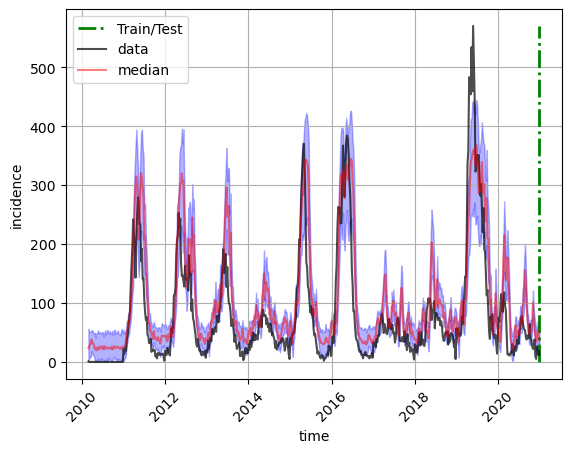

CPU times: user 2min 21s, sys: 6.33 s, total: 2min 27s
Wall time: 2min 6s


,0,1,2,3
mean_absolute_error,22.561652,24.470078,32.651810,41.345056
explained_variance_score,0.853739,0.841745,0.798498,0.723475
mean_squared_error,1357.139670,1494.234137,2180.265658,3254.281441
mean_squared_log_error,0.954035,0.921642,1.111073,1.335344
median_absolute_error,16.376787,16.064194,21.610105,28.418307
r2_score,0.851808,0.836779,0.761719,0.644220


In [23]:
%%time
model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back = LOOK_BACK, batch_size=1, loss = custom_loss_msle(p=10))

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 1.0, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK,
                  label = 'custom_msle')

See the behaviour of this model when applied in the chik data:

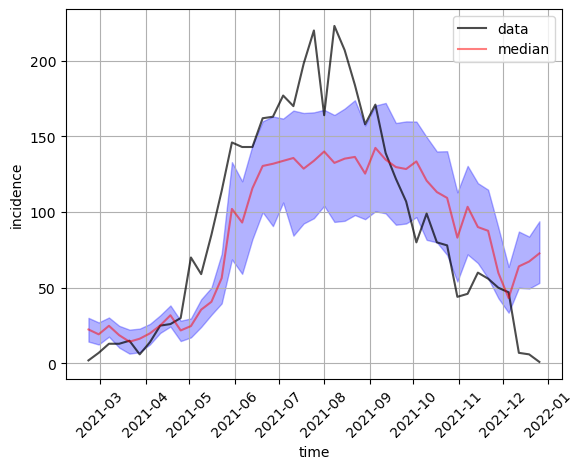

CPU times: user 11.2 s, sys: 1 s, total: 12.2 s
Wall time: 9.29 s


In [24]:
%%time
metrics = apply_dengue_chik(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, 
                     end_date = END_DATE_CHIK, look_back = LOOK_BACK,
                     predict_n = PREDICT_N,  label_m = f'custom_msle' )

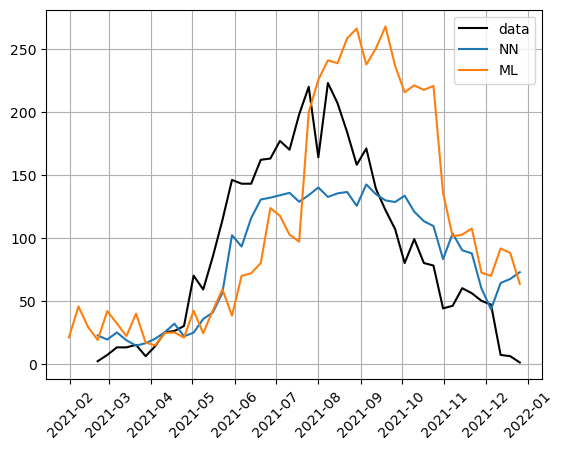

In [25]:
with open(f'../predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'../predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)
        
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [26]:
print('NN error (RMSE):', mse(data_nn['target'][:, -1] * data_nn['factor'], data_nn['pred'].iloc[:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4:], data_ml['preds'], squared = False))

NN error (RMSE): 40.62564462326049
ML error (RMSE): 71.48593479542518


Apply the transfer learning technique using this new trained model:

Compilation Time :  0.0016489028930664062
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4, 11)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             1280      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 4)                 36        
                 

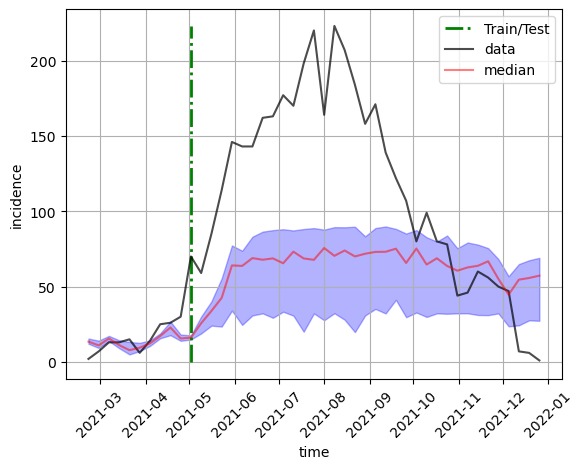

CPU times: user 15.7 s, sys: 1.25 s, total: 16.9 s
Wall time: 12.8 s


In [27]:
%%time
transf_chik_pred(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, end_train_date = END_TRAIN_CHIK,  
                            end_date = END_DATE_CHIK, filename = f'../saved_models/lstm/trained_{CITY}_model_custom_msle.h5',  epochs =100, features = 11,  
                            predict_n = PREDICT_N, look_back = LOOK_BACK, loss = custom_loss_msle(p=10), validation_split = 0.0,
                            label = f'transf_chik')

Comparing the predictions of the NN (neural network), the TL (transfer learning) and the ML (machine learning) model:

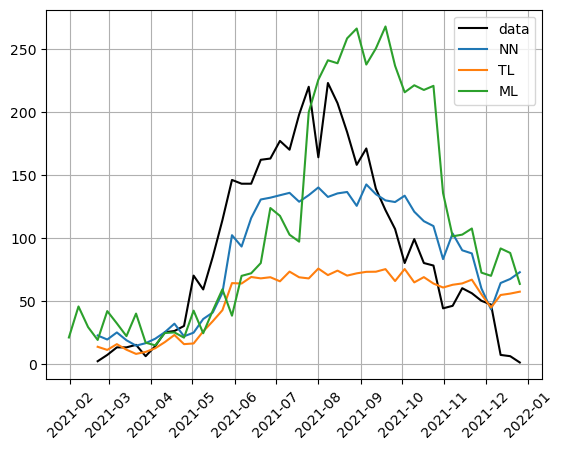

In [28]:
with open(f'../predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'../predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

with open(f'../predictions/lstm/tl_{CITY}_transf_chik.pkl', 'rb') as f:
        data_tl = pickle.load(f) 
        

plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_tl['indice'][7:],data_tl['pred'].iloc[:,-1] * data_tl['factor'], label = 'TL')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [29]:
from datetime import datetime
ini_index = data_nn['indice'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d'))
end_index = data_nn['indice'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))

print('SS compared to NN:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_nn['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_nn['factor']))
print('SS compared to ML:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_ml['preds'][ data_ml['dates'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d')): data_ml['dates'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))] ))


SS compared to NN: -0.371711177539199
SS compared to ML: -0.00036522032954766637
